# Population analysis of Asia and North America from 1955-2020
## Group 07 - Members

| **No**  | **Student ID** | **Full Name**         |
| ------- | -------------- | ----------------------|
| 1       | 20127452       | Hồ Đăng Cao           |
| 2       | 20127449       | Trần Quốc Bảo         |
| 3       | 20127476	   | Đỗ Đức Duy            |
| 4       | 20127327       | Ngô Hữu Nhật Thanh    |

---

## Import the necessary libraries

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

---

## Crawling population data from web
The dataset used for population analysising is collected from links in [Danso.org](https://danso.org/the-gioi/)

To crawling data, we go through 2 stages:

`stage 1:` Get list of links containing data of each country in area.

`stage 2:` Browse through each site in links list to crawling data.


### Stage 1: Get list of links containing df of each country in area.

- Get chrome driver to browse in `Chrome`

In [4]:
browser = webdriver.Chrome(executable_path="./chromedriver.exe")
# browser = webdriver.Chrome()

C:\Users\029at\AppData\Local\Temp\ipykernel_9376\1071397764.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(executable_path="./chromedriver.exe")


- Build function to get `html doc` from website

In [5]:
def get_html_from_link(link):
    browser.get(link)
    browser.implicitly_wait(20)
    browser.minimize_window()

    return BeautifulSoup(browser.page_source, "html.parser")

- Access `the-gioi page` to get list of `countries' raw links` (in html)

In [6]:
html_text = get_html_from_link("https://danso.org/the-gioi/")
links = html_text.find_all('h3')[:56]
links[0]

<h3 class="entry-title"><a href="https://danso.org/bermuda/">Bermuda</a></h3>

- Get `links` from `raw links`

In [7]:
links = list(map(lambda link: re.findall("<a href=\"([\w.:/-]+)\">",str(link))[0], links))
links[0]

'https://danso.org/bermuda/'

- Get `countries' names` from `links`

In [8]:
country_name = list(map(lambda x: re.findall('/([\w-]+)/',str(x))[0], links))
country_name[0]

'bermuda'

### Stage 2: Browse through each site in links list to crawling df.

At each country, there are 13 attributes, include: `Year, Population, %Change, Change, Migrate, Average age, Birth rate, Density, %urban resident, Urban resident, %world population, world population and rank`. Or only 10 attributes, without: `Average age, Birth rate, Density`.

In this project, we only care about: `Year, Population, Change, Migrate, Urban_resident`.

There are 2 main function in this stage:

- `get_table` function: Get list of data line from html text

| **No**  | **Description**| **Content**           |
| ------- | -------------- | ----------------------|
| 1       | Input          | `html_text` (str): raw html text of website           |
|         |                | `country_name`: country's name of the website         |
| ------- | -------------- | --------------------------------------------------------------------------------------------------------------|
| 2       | Output  	   | `a_table` (list of list): each element is a list containing df in each year (size: 18x6).            |
| ------- | -------------- | --------------------------------------------------------------------------------------------------------------|
| 3       | Steps          | get raw df rows (till contain html code) by `find_all` function.    |
|         |                | get data from raw rows by `re` module.    |
|         |                | remove empty rows (containing header rows).    |
|         |                | get column containing `5 attributes` that we are interested in and add `country name` as a new attribute.    |

In [9]:
def get_table(html_text, country_name):
    rows = html_text.find_all('tr',{'role':'row'})[1:20]
    a_table = list(map(lambda line: re.findall('>([\d,-N.A]+)<',str(line)), rows))
    a_table = list(filter(lambda line: len(line) > 0, a_table))
    a_table = list(map(lambda line: [country_name] + line[:2] + line[3:5] + [line[-4]], a_table))
    return a_table

- `write_to_file` function: write data table of all countries to file. 

| **No**  | **Description**| **Content**           |
| ------- | -------------- | ----------------------|
| 1       | Input          | `table` (list of list): each element is a list containing data in each year each country [size: (18 years x 56 countries) rows x 6 attributes].|
| | ------------- | --------------------------------------------------------------------------------------------------------------|
| 2       | Steps          | write name of 6 attributes to file.    |
|         |                | cast each element to `str` and get data (remove brackets).    |
|         |                | replace string `', '` with `\t` and add `\n` character.    |
|         |                | write each line of table to file.    |

In [10]:
def write_to_file(table):
    with open("data.tsv",'w') as f:
        f.write("Country\tYear\tPopulation\tChange\tMigrate\tUrban_resident\n")
        table = list(map(lambda line: str(line)[2:-2].replace("\', \'", '\t')+'\n',table))
        for line in table:
            f.write(line)

Now, it's time to combine:

- Get html text from each country site.

- Get data tables from these sites and add to table.

- Finally, write the table to file.

In [11]:
table = []
for i in range(len(links)):
    html_text = get_html_from_link(links[i])
    table += get_table(html_text, country_name[i])
write_to_file(table)

In [12]:
# Close the Chrome browser
browser.quit()

---

### Read data from tsv file into Pandas dataframe
- read file and split into lines.

- split the first line by tab character to get attributes.

- put remain lines into Pandas dataframe, then split them by tab character.

- Finally, split each rows into 6 columns.

In [29]:
with open("data.tsv") as f:
    rows = f.read().split('\n')
    keys = rows[0].split('\t')
    df = pd.DataFrame([rows[1:-1]]).apply(lambda line: line.str.split('\t'))
    df = pd.DataFrame(df.iloc[0].to_list(), columns=keys)
    
df.head()


,Country,Year,Population,Change,Migrate,Urban_resident
0,bermuda,2019,62.506,-250,1.250,60.833
1,bermuda,2018,62.756,-293,1.255,61.070
2,bermuda,2017,63.049,-313,1.261,61.349
3,bermuda,2016,63.362,-330,1.267,61.666
4,bermuda,2015,63.692,-339,1.274,62.003


---

## Data explorations

### How many rows and columns does the data have ?

In [4]:
Num_rows,Num_cols=df.shape
print(f"The data have {Num_rows} rowls")
print(f"The data have {Num_cols} columns")

The data have 1008 rowls
The data have 6 columns


### Are there any dulicate rows in the data?

In [5]:
have_dulicate_rows = df.duplicated().sum()
print("Yes dulicate") if have_dulicate_rows else print('No dulicate')

No dulicate


### What do the  columns in the data mean?

- **Country** : Name of the country
- **Year**: show the years the data was collected
- **Population**: The population of each country
- **Change**: The number of population changes
- **Migration**: The number of migratory population including immigration and emigration
- **Urban_resident**: Number of population living in urban areas

### What data type does each column currently have? 

In [6]:
df.dtypes

Country           object
Year              object
Population        object
Change            object
Migrate           object
Urban_resident    object
dtype: object

**What does columns that have object type mean?**

All columns in data have datatype of object. If the datatype of a column in dataframe is object, the datatype of elements in that column can be different from each other. so we will list the data types present in each column

In [7]:
def check_dtype(col_name):
    s = df[col_name]
    dtypes = set()
    s.apply(lambda x : dtypes.add(type(x)))
    print(f'List type in {col_name} column: {dtypes}')
    return dtypes

for col_name in df.columns:
    check_dtype(col_name)


List type in Country column: {<class 'str'>}
List type in Year column: {<class 'str'>}
List type in Population column: {<class 'str'>}
List type in Change column: {<class 'str'>}
List type in Migrate column: {<class 'str'>}
List type in Urban_resident column: {<class 'str'>}


**Issues that need to be reprocessed:**


-   The column "Country" has str data type. 
-   The  columns " Year" , "Population" , "Change"," Migrate":  data type current is string , we wil  change from str data type to int 
-    The Urban_resident column has an inappropriate value (N.A). Since in those countries there is 100% urban population, we will assign N.A to the population of that country for the year. Finally convert the values in the column to int data type.

## Preprocessing

### Convert dtype of "Urban_resident" columns to int

-    The columns 'Urban_resident' has an inappropriate value (N.A.).Values like N.A. then at that time the urban population is also the population of that country. So we change the value for N.A. Then convert to int type

In [40]:
def check_Urban_resident(x):
    return x['Population'] if x['Urban_resident']=="N.A." else x['Urban_resident']
    
df['Urban_resident']=df[['Urban_resident' ,'Population']].apply(check_Urban_resident,axis=1)
df.Urban_resident=df.Urban_resident.apply(lambda x: x.replace(".",''))
df.Urban_resident=df.Urban_resident.apply(lambda x: int(x))

### Convert dtype of" Year" , "Population" , "Change" and " Migrate" columns to int

In [41]:
df.Year = df.Year.apply(lambda x : int(x))
df.Population=df.Population.apply(lambda x: x.replace(".",''))
df.Population=df.Population.apply(lambda x: int(x))
df.Change=df.Change.apply(lambda x: x.replace(".",''))
df.Change=df.Change.apply(lambda x: int(x))
df.Migrate=df.Migrate.apply(lambda x: x.replace(".",''))
df.Migrate=df.Migrate.apply(lambda x: int(x))

Current datatype

In [42]:
df.dtypes

Country           object
Year               int64
Population         int64
Change             int64
Migrate            int64
Urban_resident     int64
dtype: object

## Data explorations (continue)

### Data distribution of columns ('Population' , 'Change' , 'Migrate' , 'Urban_resident')

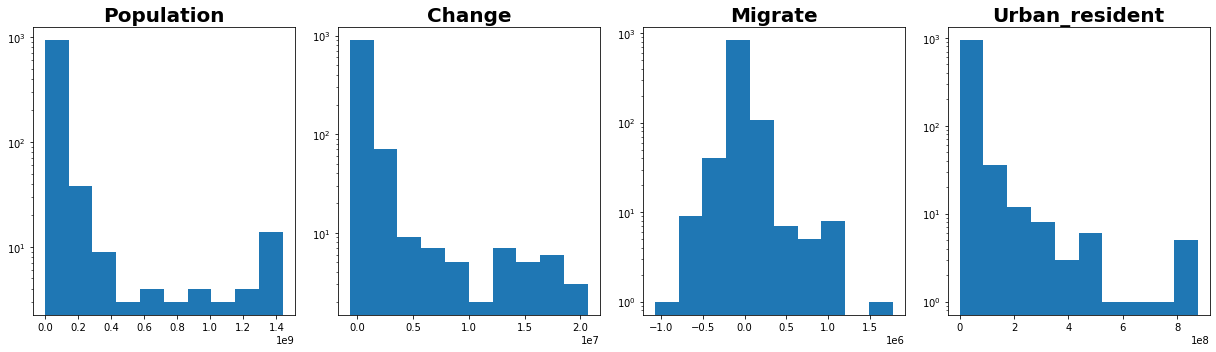

In [11]:
Arrat=df.drop("Country",axis=1)
Arrat=Arrat.drop("Year",axis=1)
fig, axs=plt.subplots(1, len(Arrat.columns), figsize=(17,5))
for i , ax in enumerate(axs.flat):
    ax.hist(Arrat.iloc[:,i] )
    ax.set_title(Arrat.columns[i],fontsize=20,fontweight='bold')
    ax.semilogy()
   
plt.tight_layout()

-   `Comment`
    -  Data distribution table of columns Population , Change , Migrare , Urban_resident
    - In the Migrate column , there are negative and positive values . Negative value indicates the migrant countries. Positive value indicates the immigrant countries
    - In the Change column, there are positive and negative values. A negative value indicates that the population of that country has decreased compared to the population of the previous data update. A positive value indicates an increase in the population of that country compared to the population of the previous data update
    - So negative signs are just formal marks to indicate a certain meaning without affecting the value

### Data distribution of columns ('Year')

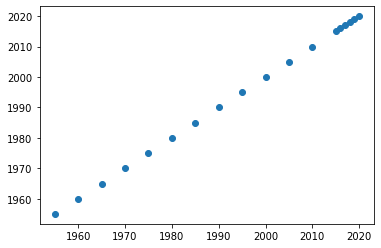

In [12]:
year_arr=df['Year'].sort_values().unique()
plt.scatter(year_arr,year_arr )
plt.show()

-  `Comment` 
   - In the Year column, there are years from 1995 to 2020 and the distribution is not uniform
   - From 1955 to 2015, Each data update is 5 years apart. And from 2015 to 2020 they are only 1 year apart.

### Data distribution of columns ('Country')

#### We collect data for 56 countries in Asia and North America

-   `Countries in Asia`

In [13]:
Country_arr=df['Country'].unique()
Asia={}
Asia['Asia']=Country_arr[5:]
Asia=pd.DataFrame(Asia)
Asia=Asia.T
Asia.head()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
Asia,a-rap-xe-ut,afghanistan,an-do,armenia,azerbaijan,bahrain,bangladesh,bhutan,brunei,cac-tieu-vuong-quoc-a-rap-thong-nhat,...,syria,tajikistan,thai-lan,tho-nhi-ky,trieu-tien,trung-quoc,turkmenistan,uzbekistan,viet-nam,yemen


- `Countries in North America`

In [14]:
North_America={}
North_America['North America']=Country_arr[:5]
North_America=pd.DataFrame(North_America)
North_America=North_America.T
North_America.head()


,0,1,2,3,4
North America,bermuda,canada,greenland,hoa-ky,saint-pierre-va-miquelon


### For each column with numeric data types, how are the values distributed?

- There appear to be 5 columns in the numeric group right now: 'Year' , 'Population','Change','Migrate','Urban_resident'
- I will compute the percentage of missing values (from 0 to 100), the minimum and maximum for each numeric column .The results are saved to the dataframe `Nume_col_data`

In [15]:
nume_col_df = df.select_dtypes(exclude='object')
df1 = pd.DataFrame([
    nume_col_df.isna().mean() * 100]
    , index=["missing_ratio"])
df2 = nume_col_df.describe()
Nume_col_data = np.round(pd.concat([df1, df2], axis=0))
Nume_col_data



,Year,Population,Change,Migrate,Urban_resident
missing_ratio,0.0,0.000000e+00,0.0,0.0,0.0
count,1008.0,1.008000e+03,1008.0,1008.0,1008.0
mean,1994.0,6.595670e+07,855175.0,1897.0,28341910.0
std,22.0,2.080674e+08,2545136.0,167680.0,88811065.0
min,1955.0,4.755000e+03,-673024.0,-1077397.0,3942.0
25%,1975.0,2.083358e+06,32502.0,-20000.0,914024.0
50%,1998.0,8.323390e+06,122130.0,0.0,3750898.0
75%,2016.0,3.279276e+07,523006.0,15645.0,15720951.0
max,2020.0,1.439324e+09,20676485.0,1771991.0,875075919.0


`Comment:` Data cleaning and processing is quite good so 100% no data is missing.Ready to answer questions

## Ask a meaningful question

There are five number of questions that can be answered with data after exploring it and better understanding it:
-   Which are immigrant countries and migrant countries
-   Migration rate of countries in the region over the year => Find top 3 immigrant/migrant countries
-   Average population growth rate of countries from 1955 to 2020 year
-   The most/least populous country in area in each year
-   Calculate average population of countries in a period

### Which are immigrant countries and migrant countries

- `Migrant countries`

In [16]:
Migrant_countries={}
Immigrant_countries={}
Migrant_countries['Country']=[]
Migrant_countries['Migrate']=[]
Immigrant_countries['Country']=[]
Immigrant_countries['Migrate']=[]

def Check_Migrant(x):
    if x['Migrate'] < 0:
        Migrant_countries['Country'].append(x['Country'])
        Migrant_countries['Migrate'].append(x['Migrate'])
    elif x['Migrate'] >0:
        Immigrant_countries['Country'].append(x['Country'])
        Immigrant_countries['Migrate'].append(x['Migrate'])
Temp=df[['Country','Migrate']]
Temp=Temp.groupby('Country').mean().reset_index()
Temp.apply(Check_Migrant,axis=1)
Migrant_countries=pd.DataFrame(Migrant_countries)
KQ=Migrant_countries[['Country']].T
KQ.head()


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Country,afghanistan,an-do,armenia,azerbaijan,bangladesh,bhutan,campuchia,dong-timo,georgia,indonesia,...,philippines,sri-lanka,syria,tajikistan,trieu-tien,trung-quoc,turkmenistan,uzbekistan,viet-nam,yemen


-   `Immigrant countries`

In [17]:
Immigrant_countries=pd.DataFrame(Immigrant_countries)
KQ=Immigrant_countries[['Country']].T
KQ.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Country,a-rap-xe-ut,bahrain,bermuda,brunei,cac-tieu-vuong-quoc-a-rap-thong-nhat,canada,cong-hoa-sip,dai-loan,han-quoc,hoa-ky,...,ma-cao,malaysia,maldives,nhat-ban,oman,qatar,saint-pierre-va-miquelon,singapore,thai-lan,tho-nhi-ky


### Migration rate of countries in the region over the year => Find top 5 immigrant/migrant countries

-   Top 5 Migrant countries

In [18]:
def TinhToan(x):
    return (x['Migrate']/x['Population'])*1000
def abs_x(x):
    return abs(x)
Top5_Migrant=df[['Country' ,'Population' ,'Migrate']].loc[df['Country'].isin(Migrant_countries['Country'].unique())]
Top5_Migrant['Migrate']=Top5_Migrant['Migrate'].apply(abs_x)
Top5_Migrant['Tyle']=Top5_Migrant[['Population','Migrate']].apply(TinhToan,axis=1)
Top5_Migrant=Top5_Migrant[['Country','Tyle']].groupby('Country').mean().sort_values('Tyle').reset_index()
Top5_Migrant['Tyle']=Top5_Migrant['Tyle'].apply(lambda x: abs(x))
Top5_Migrant= Top5_Migrant.tail(5)
Top5_Migrant=Top5_Migrant.set_index("Country")
Top5_Migrant.head()

,Tyle
Country,
kazakhstan,6.189694
armenia,6.718504
palestine,8.719181
afghanistan,9.261272
syria,11.626894


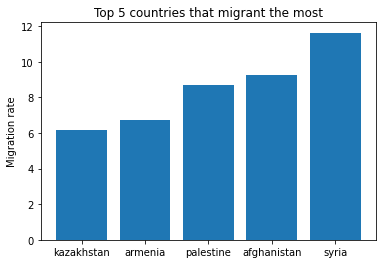

In [20]:
y=np.arange(len(Top5_Migrant.index.array))
x=Top5_Migrant['Tyle']
plt.bar(y,x)
plt.xticks(y,Top5_Migrant.index)
plt.ylabel('Migration rate')
plt.title('Top 5 countries that migrant the most')
plt.show()

-  Top 5 Immigrant countries

In [22]:
def TinhToan(x):
    return (x['Migrate']/x['Population'])*1000
Top5_immigrant=df[['Country' ,'Population' ,'Migrate']].loc[df['Country'].isin(Immigrant_countries['Country'].unique())]
Top5_immigrant['Tyle']=Top5_immigrant[['Population','Migrate']].apply(TinhToan,axis=1)
Top5_immigrant=Top5_immigrant[['Country','Tyle']].groupby('Country').mean().sort_values('Tyle',ascending=False).reset_index()
Top5_immigrant= Top5_immigrant.head(5)
Top5_immigrant=Top5_immigrant.set_index("Country")
Top5_immigrant.head()

,Tyle
Country,
qatar,30.756632
cac-tieu-vuong-quoc-a-rap-thong-nhat,30.201535
bermuda,20.000191
bahrain,16.801409
kuwait,14.424274


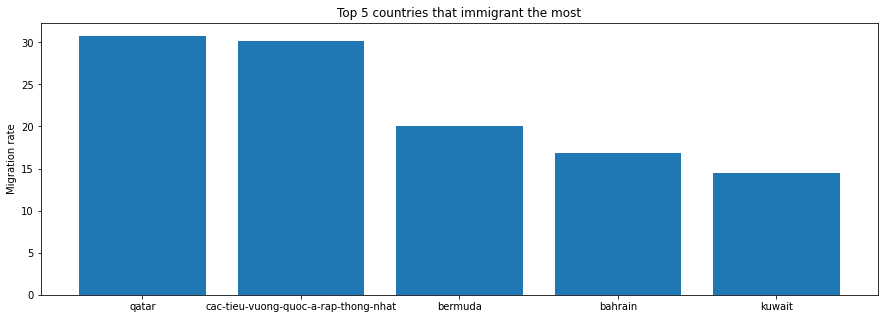

In [23]:
plt.figure(figsize=(15,5))
y=np.arange(len(Top5_immigrant.index.array))
x=Top5_immigrant['Tyle']
plt.bar(y,x)
plt.xticks(y,Top5_immigrant.index)
plt.ylabel('Migration rate')
plt.title('Top 5 countries that immigrant the most')
plt.show()

`Comment`: Based on data on migration that country can make policies on workers social security ....

### Average population growth rate of countries from 1955 to 2020 year

In [24]:
NameCountry_arr=df['Country'].unique()
Aver_growt_data={}
Aver_growt_data['Country']=[]
Aver_growt_data['Average annual population growth rate']=[]
for i in NameCountry_arr:
    KQ=[]
    Aver_growt_rate=df[['Year','Country','Population']][df['Country']==i].sort_values('Year',ascending=False)
    size_arr=len(Aver_growt_rate)
    Aver_growt_rate.index=range(1,size_arr+1)
    Toal=Aver_growt_rate['Population'][1] / Aver_growt_rate['Population'][18]
    Toal=Toal**(1/(Aver_growt_rate['Year'][1]-Aver_growt_rate['Year'][18]))
    Toal=Toal-1
    Aver_growt_data['Country'].append(i)
    Aver_growt_data['Average annual population growth rate'].append(Toal)
Aver_growt_data=pd.DataFrame(Aver_growt_data) 
Aver_growt_data=Aver_growt_data.sort_values('Average annual population growth rate',ascending=False)
Aver_growt_data=Aver_growt_data.head(5).set_index("Country")
Aver_growt_data



,Average annual population growth rate
Country,
cac-tieu-vuong-quoc-a-rap-thong-nhat,0.077015
qatar,0.069808
kuwait,0.049754
jordan,0.042477
bahrain,0.039924


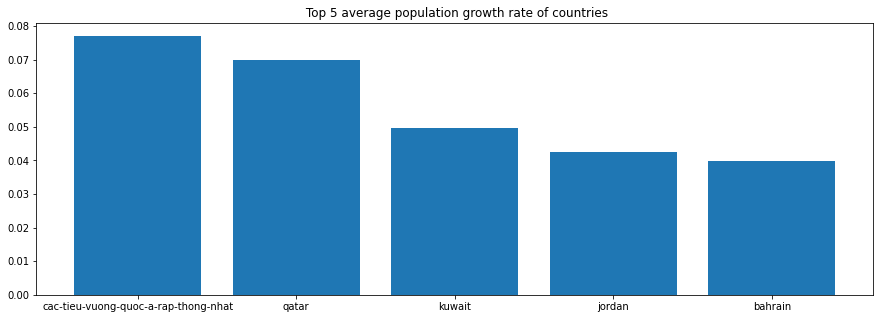

In [112]:
plt.figure(figsize=(15,5))
y=np.arange(len(Aver_growt_data.index.array))
x=Aver_growt_data['Average annual population growth rate']
plt.bar(y,x)
plt.xticks(y,Aver_growt_data.index)
plt.title(' Top 5 average population growth rate of countries')
plt.show()


`Comment`: Based on the average growth rate, we can make judgments about how fast or slow population growth affects people's lives and economy.

### The most/least populous country in area in each year

In [69]:
def MinMaxPl(a):
    Temp=df[['Year','Country','Population']]
    A=a.values
    A=A[0]
    Temp=Temp[Temp.Country.isin(A)]
    Temp=Temp.pivot(index='Year',columns='Country',values='Population')
    Populous_most_least={}
    if len(A)> 5:
        Populous_most_least['Most populous in ASIA']=Temp.idxmax(axis=1).values
        Populous_most_least['Min populous in ASIA']=Temp.idxmin(axis=1).values
    else: 
        Populous_most_least['Most populous in North America']=Temp.idxmax(axis=1).values
        Populous_most_least['Min populous in North America']=Temp.idxmin(axis=1).values
    Populous_most_least=pd.DataFrame(Populous_most_least,index=Temp.index)
    return Populous_most_least

Asia_population=MinMaxPl(Asia)
NorthAmerica_population=MinMaxPl(North_America)
Sum_Asia_NorthAmerica= pd.concat([Asia_population,NorthAmerica_population] ,axis=1)
Sum_Asia_NorthAmerica

,Most populous in ASIA,Min populous in ASIA,Most populous in North America,Min populous in North America
Year,,,,
1955,trung-quoc,qatar,hoa-ky,saint-pierre-va-miquelon
1960,trung-quoc,qatar,hoa-ky,saint-pierre-va-miquelon
1965,trung-quoc,qatar,hoa-ky,saint-pierre-va-miquelon
1970,trung-quoc,qatar,hoa-ky,saint-pierre-va-miquelon
1975,trung-quoc,maldives,hoa-ky,saint-pierre-va-miquelon
1980,trung-quoc,maldives,hoa-ky,saint-pierre-va-miquelon
1985,trung-quoc,maldives,hoa-ky,saint-pierre-va-miquelon
1990,trung-quoc,maldives,hoa-ky,saint-pierre-va-miquelon
1995,trung-quoc,maldives,hoa-ky,saint-pierre-va-miquelon


### Compare the population of 2 continents from 1955 - 2020

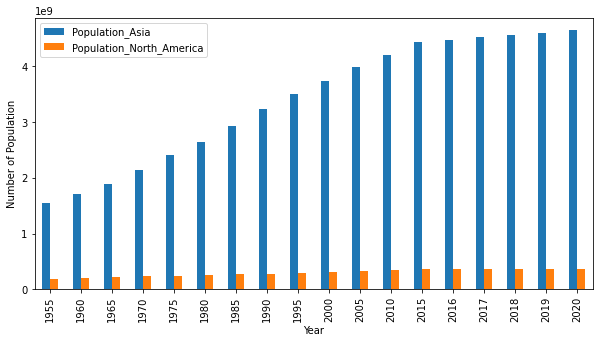

In [107]:
Asia=Asia.T
Country_Asia=Asia.values.reshape(-1)
Asia_sum=df[df.Country.isin(Country_Asia)].reset_index().drop("index",axis=1)
Asia_sum=Asia_sum[["Year","Population"]]
Asia_sum=Asia_sum.groupby("Year").sum()
Asia_sum=Asia_sum.rename(columns={"Population": "Population_Asia"})


North_America=North_America.T
Country_North_America=North_America.values.reshape(-1)
North_America_sum=df[df.Country.isin(Country_North_America)].reset_index().drop("index",axis=1)
North_America_sum=North_America_sum[["Year","Population"]]
North_America_sum=North_America_sum.groupby("Year").sum()
North_America_sum=North_America_sum.rename(columns={"Population": "Population_North_America"})
Compare_population=pd.concat([Asia_sum,North_America_sum],axis=1)


Compare_population.plot.bar(figsize=(10,5))
plt.xlabel('Year'); plt.ylabel('Number of Population') 
plt.show()


`Comment:` The big difference between the population of the two continents

## Building model
---

### Step 1: Let's explore some infomations from data of column population and year of the data frame before bulding model.

Choose the bermuda country for some explores.

In [ ]:
bermudaInfo = df.loc[df.Country == 'bermuda']
bermudaInfo.head(5)

,Country,Year,Population,Change,Migrate,Urban_resident
0,bermuda,2019,62506,-250,1250,60833
1,bermuda,2018,62756,-293,1255,61070
2,bermuda,2017,63049,-313,1261,61349
3,bermuda,2016,63362,-330,1267,61666
4,bermuda,2015,63692,-339,1274,62003


In [ ]:
bermudaInfo = bermudaInfo[['Year','Population']].sort_values('Year')
bermudaInfo.head(5)

,Year,Population
16,1955,40708
15,1960,44979
14,1965,49388
13,1970,52565
12,1975,55400


Visualize the data of bermuda country.

C:\Users\ACER\AppData\Local\Temp\ipykernel_1256\3263927871.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0, 0.5, 'Population')

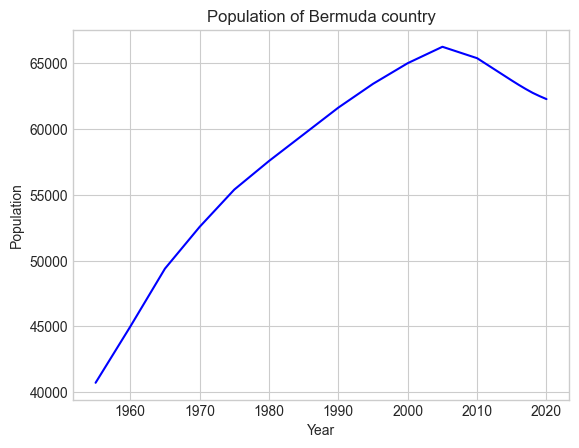

In [ ]:
plt.style.use('seaborn-whitegrid')
xIndex = np.array(bermudaInfo.Year)
yIndex = np.array(bermudaInfo.Population)
plt.plot(xIndex, yIndex, color = 'blue')
plt.title(f"Population of Bermuda country")
plt.xlabel("Year")
plt.ylabel("Population")

### Step 2: After exploring we start finding insight of data given and build model.

##### - We will build the model that can predict population of the country in the future and we use linear regression method to build.

- Using model: `y = a_0*x^0 + a_1*x^1 + ..... + a_n*x^n.`

- Caculate a (a_0, a_1, .... a_n) by using the formula: `(A^T * A)^-1 * A^T *B.`

        With:
            A = [theta_0...theta_n]  :list years.
                [theta_0...theta_n]
                [  .         .    ]
                [  .         .    ]
                [theta_0...theta_n]
            Size of A: m nows x n + 1 columns.
            Ex: If we have list years: 2011 2012 2013 2014 (m = 4) and n is 2, A will be:
                [2011^0 2011^1 2011^2]
                [2012^0 2012^1 2012^2]
                [2013^0 2013^1 2013^2]
                [2014^0 2014^1 2014^2]

            B = [y0]  :list values of field.
                [y1]
                [. ]
                [. ]
                [yn]
            Size of B: m nows x 1 columns.
            Ex: If we have list years: 2011 2012 2013 2014 and population for each year is: 100 200 300 400 (m = 4), B will be:
                [100]
                [200]
                [300]
                [400]
                    
- Calculate the residual value using the formula: `||r|| = ||A*x – B||.`

        With:
            x = (A^T * A)^-1 * A^T *B
              = [a_0]
                [a_1]
                [ . ]
                [ . ]
                [a_n]

##### Model: Build model base on the formula given.
---

#### Build processing.

- Prepare data for caculation by the way give list values of field and year from data frame.</br>
    - Input: data frame, name of country and field of data you want to predict.</br>
    - Output: data for predict processing.</br>

In [ ]:
def prepareDataForCalculate(country,dataFrame,field):
    countryInfo = dataFrame.loc[(dataFrame.Country == country),['Year',field]]
    countryInfo = countryInfo.sort_values('Year')
    # Change data for suitable to caculate
    xIndex = np.array(countryInfo.Year)
    yIndex = np.array(countryInfo[field])
   
    return xIndex, yIndex

- Give data and remake data for using formula to caculate meaningful values.</br>
    - Input: data for processing and max pow of x varible in function f(x).</br>
    - Output: vecter A, vecter B and thetahat vecter for caculate the residual value of model.</br>

In [ ]:
def calValueForModel(xIndex,yIndex,powN):
    powN = int(powN)
    size = len(xIndex)
    A = xIndex.reshape(-1,1)
    root = np.copy(A)
    x0Index = np.ones(len(xIndex))

    x0Index= x0Index.reshape(-1,1)
    A = np.append(x0Index,A,axis=1)

    yIndex = yIndex.reshape(-1,1)

    for i in range(2,powN+1):
        xJ = np.ones(size)
        xJ = xJ.reshape(-1,1)
        for j in range(i):
            xJ = np.array(xJ*root)
        A = np.append(A,xJ,axis=1)

    B = np.array(yIndex)
    # Caculate parameters
    thetaHat = np.linalg.inv(A.T@A)@(A.T@B)
    return A,B, thetaHat

- Caculate the residual value of model
    - Input: vecter A, vecter B and thetahat vecter.
    - Output: the residual value of model.

In [ ]:
def caculateNormR(A, B, thetaHat):
    R = np.linalg.norm(A@thetaHat - B)
    return R

- Build model by using functions had been built. Main point is find R and x that is mention of formula.

In [ ]:
def buildModelField(country,dataFrame,field,powN):
    xIndex, yIndex = prepareDataForCalculate(country,dataFrame,field)
    A,B, thetaHat = calValueForModel(xIndex,yIndex,powN)
    R = caculateNormR(A, B, thetaHat)
    return thetaHat, R

- Find the best rank of model when using maximum of n is 45, that is decision by residual value (R). So, the target of 
this function is finding minimum R then return the rank at minimum R.

In [ ]:
def findTheBestNForMinRField(country,field,dataFrame):
    # The maximum size that computer can caculate. 
    maxSize = 45
    rArray = []
    for i in range(1,maxSize):
        theta, R = buildModelField(country,dataFrame,field,i)
        rArray.append(R)
    rArray = np.array(rArray)
    minValue = np.amin(rArray)
    minPos = np.where(rArray == minValue)
    minPos = np.amin(minPos)

    return minPos, minValue

- Print infomation of field you want to predict and give some evaluations about model will be built.

In [ ]:
def printInfoField(country,field,powN,minR):
    print(f"Predict {field} for {country} country.")
    print(f"The minimum value of R is: {minR}, and N (maximum power of x) is: {powN}.")
    print(f"The above information means that the {field} deviation when using the X^({powN}) model to predict is from real data.")

- Caculate value of y (the function given initially) after finding all variable.
    - Input: list of year, array of thetahat vecter.
    - Output: value of y.

In [ ]:
def caculateFieldForYear(array,year):
    arrayUse = array.reshape(-1)
    yearUse = float(year)
    temp = np.copy(arrayUse[0])
    sumP  = temp
    for i in range(1,len(arrayUse)):
        sumP = sumP + float((np.power(yearUse,i))*float(arrayUse[i]))
    return sumP

- Predict field base on model. Using functions having been built, step by step create model and then caculate value.

In [ ]:
def predictField(country,field,dataFrame,year,powN):
    theta, R = buildModelField(country,dataFrame,field,powN)
    large = round(caculateFieldForYear(theta,year))
    print(f"- The {field} of {country} in {year} is: {float(large)}, the residual is: {R}.")

- Visualize for comparing predict model had been built with real data. 

In [ ]:
def compareModelWithRealData(array,listYear,listYReal, countryName):
    array = array.reshape(-1)
    listPop = np.zeros(len(listYear))
    temp = np.copy(array[0])

    for index in range(len(listYear)):
        sumPop = temp
        for i in range(1,len(array)):
            sumPop = sumPop + float(np.power(listYear[index],i)*float(array[i]))
        listPop[index] = sumPop
        
    plt.plot(listYear,listPop, color = 'red', label = 'Predict model.');
    plt.scatter(listYear,listYReal, color = 'blue', label = 'Real data.');
    plt.xlabel("Year");
    plt.ylabel("Population");
    plt.title(f"Comprare chart of {countryName} country")
    plt.legend(); 

- Synthetic informations for comparing predict model with real data.  

In [ ]:
def compareFieldWithRealData(country,field,dataFrame,powN):
    listX, listY = prepareDataForCalculate(country,dataFrame,field)
    theta, R = buildModelField(country,dataFrame,field,powN)
    compareModelWithRealData(theta,listX,listY,country)


##### Testing model.

- Prepare data.

In [ ]:
listField = list(df.columns)
listField

['Country', 'Year', 'Population', 'Change', 'Migrate', 'Urban_resident']

In [ ]:
listCountry = df.Country.unique()
listCountry = [i for i in listCountry]
print(listCountry)

['bermuda', 'canada', 'greenland', 'hoa-ky', 'saint-pierre-va-miquelon', 'a-rap-xe-ut', 'afghanistan', 'an-do', 'armenia', 'azerbaijan', 'bahrain', 'bangladesh', 'bhutan', 'brunei', 'cac-tieu-vuong-quoc-a-rap-thong-nhat', 'campuchia', 'cong-hoa-sip', 'dai-loan', 'dong-timo', 'georgia', 'han-quoc', 'hong-kong', 'indonesia', 'iran', 'iraq', 'israel', 'jordan', 'kazakhstan', 'kuwait', 'kyrgyzstan', 'lao', 'lebanon', 'ma-cao', 'malaysia', 'maldives', 'mong-co', 'myanmar', 'nepal', 'nhat-ban', 'oman', 'pakistan', 'palestine', 'philippines', 'qatar', 'singapore', 'sri-lanka', 'syria', 'tajikistan', 'thai-lan', 'tho-nhi-ky', 'trieu-tien', 'trung-quoc', 'turkmenistan', 'uzbekistan', 'viet-nam', 'yemen']


Now, let's make some predictions with canada.

- Check the quality of the model.

In [ ]:
powFieldValue, minRFieldValue = findTheBestNForMinRField(listCountry[1],listField[5],df)
printInfoField(listCountry[1],listField[2],powFieldValue, minRFieldValue)

Predict Population for canada country.
The minimum value of R is: 893067.1595161122, and N (maximum power of x) is: 2.
The above information means that the Population deviation when using the X^(2) model to predict is from real data.


- Predict population of canada in 2019.

In [ ]:
predictYear = 2019
predictField(listCountry[1],listField[2],df,predictYear,powFieldValue)

- The Population of canada in 2019 is: 37318721.0, the residual is: 1002864.9460016815.


- Compare real data with predict's model data.

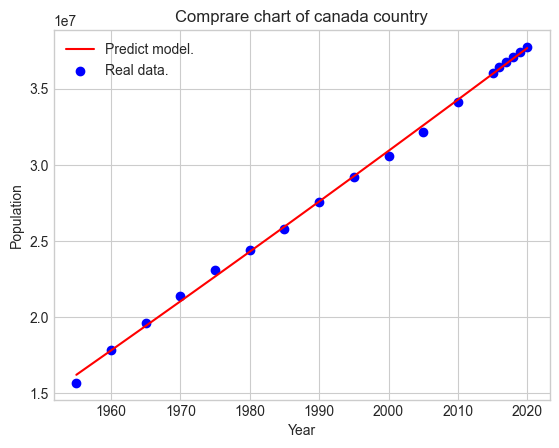

In [ ]:
compareFieldWithRealData(listCountry[1],listField[2],df,powFieldValue)

### Using scikitlearn model
---


#### **<font color='blue'>Model 1.0</font>**. Choose one of two models: multi linear regression or polynomial regresion based on the prediction results of the two models on the data set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.metrics import mean_squared_error


- Prepare data for multi linear regression model.

In [ ]:
def getDataForMTLinear(countryName,fieldPredict,listField):
    listData = []
    for i in listField:
        if i != fieldPredict:
            listData.append(i)

    result = df.loc[(df.Country == countryName),fieldPredict]
    data = df.loc[(df.Country == countryName),listData]
    data = data.drop(['Country'],axis = 1)

    return data, result

- Prepare data for polynomial regression model.

In [ ]:
def getDataForPLLinear(countryName,fieldPredict,fieldData):
    result = df.loc[(df.Country == countryName),fieldPredict]
    data = df.loc[(df.Country == countryName),fieldData]

    return data, result


In [ ]:
print(listCountry)

['bermuda', 'canada', 'greenland', 'hoa-ky', 'saint-pierre-va-miquelon', 'a-rap-xe-ut', 'afghanistan', 'an-do', 'armenia', 'azerbaijan', 'bahrain', 'bangladesh', 'bhutan', 'brunei', 'cac-tieu-vuong-quoc-a-rap-thong-nhat', 'campuchia', 'cong-hoa-sip', 'dai-loan', 'dong-timo', 'georgia', 'han-quoc', 'hong-kong', 'indonesia', 'iran', 'iraq', 'israel', 'jordan', 'kazakhstan', 'kuwait', 'kyrgyzstan', 'lao', 'lebanon', 'ma-cao', 'malaysia', 'maldives', 'mong-co', 'myanmar', 'nepal', 'nhat-ban', 'oman', 'pakistan', 'palestine', 'philippines', 'qatar', 'singapore', 'sri-lanka', 'syria', 'tajikistan', 'thai-lan', 'tho-nhi-ky', 'trieu-tien', 'trung-quoc', 'turkmenistan', 'uzbekistan', 'viet-nam', 'yemen']


In [ ]:
listField

['Country', 'Year', 'Population', 'Change', 'Migrate', 'Urban_resident']

##### Now, we try to use model to predict population in canada country.

Multi linear regression.

In [ ]:
needPredict = listField[2]
countryPredict = listCountry[1]

In [ ]:
data, result = getDataForMTLinear(countryPredict ,needPredict,listField)

In [ ]:
X = data.iloc[:,:].values
y = result.iloc[:].values
X2 = np.array(np.copy(X))
yearTest = np.copy(X2[:,0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [ ]:
sc = StandardScaler()
X_train[:,:] = sc.fit_transform(X_train[:,:])
X_test[:,:] = sc.transform(X_test[:,:])
X2[:,:] = sc.transform(X2[:,:])

In [ ]:
lR = LinearRegression()
lR.fit(X_train, y_train)

LinearRegression()

- Evaluate the model on the training set.

In [ ]:
lR.score(X_train, y_train)

0.9480977475525618

In [ ]:
y_preds = lR.predict(X_test)

In [ ]:
y_test = np.array(y_test)

- Evaluate the model on predicting.

In [ ]:
np.sqrt(mean_squared_error(y_test,y_preds ))

4583418.606281839

- Convert data to visualize in chart.

In [ ]:
def convertDataToVisualize(y_preds,y_test,yearTest):
    y_preds = np.array(y_preds).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    yearTest = np.array(yearTest).reshape(-1,1)
    compareData = np.append(yearTest,y_test,axis=1)
    compareData = np.append(compareData,y_preds,axis=1)
    compareData = pd.DataFrame(compareData,columns = ['Year','Predict','Real'])
    compareData = compareData.sort_values('Year')

    return compareData

In [ ]:
y_preds_all = lR.predict(X2)
compareData = convertDataToVisualize(y_preds_all,y,yearTest)

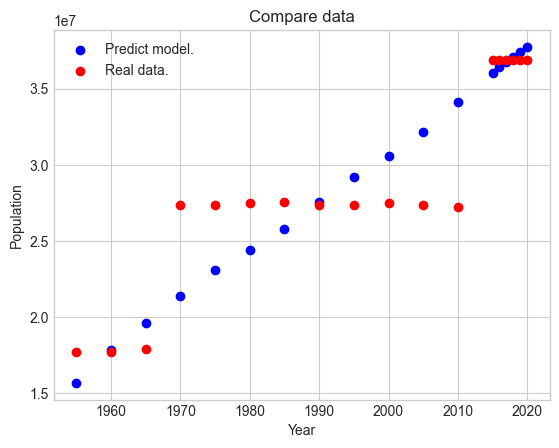

In [ ]:
plt.scatter(compareData.Year,compareData.Predict, color = 'blue', label = 'Predict model.');
plt.scatter(compareData.Year,compareData.Real, color = 'red', label = 'Real data.');
plt.title('Compare data')
plt.xlabel("Year");
plt.ylabel("Population");
plt.legend(); 

Polynomial regression.

In [ ]:
needPredict = listField[2]
countryPredict = listCountry[1]
dataField = listField[5]

In [ ]:
data1, result1 = getDataForPLLinear(countryPredict,needPredict,dataField)

X2 = np.copy(data1)
y = np.copy(result1)
X2 = np.array(X2).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [ ]:
poly_reg = PolynomialFeatures(degree = 2) #Random degree
X_poly = poly_reg.fit_transform(X2)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state = 1)

In [ ]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly_train, y_train)

LinearRegression()

- Evaluate the model on the training set.

In [ ]:
lin_reg_2.score(X_poly_train, y_train)

0.9996629536176946

In [ ]:
yPolyPreds = lin_reg_2.predict(X_poly_test)

- Evaluate the model on predicting.

In [ ]:
np.sqrt(mean_squared_error(y_test,yPolyPreds))

274531.5844494875

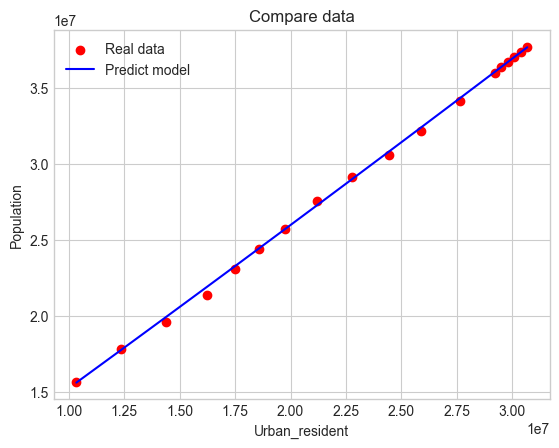

In [ ]:
yPolyPredsAll = lin_reg_2.predict(X_poly)
plt.scatter(X2, y, color = 'red',label = 'Real data' )
plt.plot(X2, yPolyPredsAll, color = 'blue', label = 'Predict model')
plt.title('Compare data')
plt.xlabel(dataField)
plt.ylabel(needPredict)
plt.legend()
plt.show()

- `Comment on 2 machine learning models:`

We see that the results of multi linear regression for population prediction are not really good, the error is still quite large. Polynomial regresion gives better results, but the results are mainly based on the fields and degrees that we use to build the model. So to continue we will use model 2 but first we need to find the appropriate data field and order and then build the model.

#### **<font color='blue'>Model 2.0</font>**. Build polynomial regression model.

We try to find the field to predict by using cross validation (**<font color='green'>y = a_0 + a_i*x_i</font>**), then we use the best field to find the best degree by using the residual to evaluate the best field.

- Caculate data to find R and thetahat vector.

In [ ]:
def findRAndTheta(fieldData, fieldResult):
    thetaHat = np.linalg.inv(fieldData.T@fieldData)@(fieldData.T@fieldResult)
    rValue = np.linalg.norm(fieldData@thetaHat - fieldResult)
    return rValue, thetaHat

In [ ]:
def calValueForModel2(fieldData,fieldResult,powN):
    
    powN = int(powN)
    size = len(fieldData)
    A = np.array(np.copy(fieldData))
    root = np.copy(A)
    x0Index = np.ones(len(fieldData))

    x0Index= x0Index.reshape(-1,1)
    A = np.append(x0Index,A,axis=1)

    for i in range(2,powN+1):
        xJ = np.ones(size)
        xJ = xJ.reshape(-1,1)
        for j in range(i):
            xJ = np.array(xJ*root)
        A = np.append(A,xJ,axis=1)
    
    expandVector = np.array(np.copy(A))
    B = np.array(np.copy(fieldResult))
    rValue, thetaHat = findRAndTheta(A,B)

    return rValue, thetaHat, expandVector

- Find the best column field for predict field

In [ ]:
def findTheBestField(dataFrame,countryName,listField,fieldResult):
    
    countryInfo = dataFrame.loc[(dataFrame.Country == countryName)]
    result = np.array(countryInfo[fieldResult],dtype=float).reshape(-1,1)
    scoreArray = []
    choiceField = []
    for i in listField:
        if i != 'Country' and i != fieldResult:
            data = np.array(countryInfo[i],dtype=float).reshape(-1,1)
            R,thetaHat,expandVector = calValueForModel2(data,result,1)
            choiceField.append(i)
            lin_reg_2 = LinearRegression()
            expandVectorTrain, expandVectorTest, result_train, result_test = train_test_split(expandVector, result, test_size = 0.3, random_state = 1)
            lin_reg_2.fit(expandVectorTrain, result_train)
            score = lin_reg_2.score(expandVectorTrain, result_train)
            poly_reg_rmse = np.sqrt(mean_squared_error(result_test, lin_reg_2.predict(expandVectorTest)))
            rs = float((poly_reg_rmse + R + score)/3)
            scoreArray.append(rs)

    scoreArray = np.array(scoreArray)
    minValue = np.amin(scoreArray)
    minPos = np.where(scoreArray == minValue)
    minPos = np.amin(minPos)

    return countryInfo, minValue, fieldResult, choiceField[minPos], result
        

- Find the best degree for the best field.

In [ ]:
def findParameter(dataFrame,countryName,listField,fieldResult):
    countryInfo, minR, fieldResult, bestField, result = findTheBestField(dataFrame,countryName,listField,fieldResult)
    data = np.array(countryInfo[bestField],dtype=float).reshape(-1,1)
    maxSize = 10
    scoreArray = []
    thetaArray = []
    powArray = []
    trainScore = []
    listExpandVector = []

    for i in range(1,maxSize):
        rValue, thetaHat, expandVector = calValueForModel2(data,result,i)
        thetaArray.append(thetaHat)
        powArray.append(i)
        listExpandVector.append(expandVector)
        lin_reg_2 = LinearRegression()
        y = np.array(np.copy(result))
        expandVectorTrain, expandVectorTest, y_train, y_test = train_test_split(expandVector, y, test_size = 0.3, random_state = 1)
        lin_reg_2.fit(expandVectorTrain, y_train)
        score = lin_reg_2.score(expandVectorTrain, y_train)
        poly_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_2.predict(expandVectorTest)))
        rs = float((poly_reg_rmse + rValue + score)/3)
        trainScore.append(score)
        scoreArray.append(rs)
           
    scoreArray = np.array(scoreArray)
    minValue = np.amin(scoreArray)
    minPos = np.where(scoreArray == minValue)
    minPos = np.amin(minPos)

    return bestField, minValue, trainScore[minPos], thetaArray[minPos], powArray[minPos], listExpandVector[minPos], data, result

- Build polynomial regression model.

In [ ]:
def polyResgressionBuilt(data,result,expandVector):
    
    X0 = np.copy(data)
    X0 = np.array(X0).reshape(-1,1)
    X = np.array(np.copy(expandVector))
    y = np.copy(result)
    y = np.array(y).reshape(-1,1)
    lin_reg_2 = LinearRegression()
    X_poly_train, X_poly_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    lin_reg_2.fit(X_poly_train, y_train)
    Evaluate = lin_reg_2.score(X_poly_train, y_train)
    
    return X0, y, lin_reg_2.predict(X), Evaluate

    

- Visualize data for model.

In [ ]:
def visualizeDataForPoly(X,y,yPreds,fieldPredict,fieldWantToPredict):
        
        plt.scatter(X, y, color = 'red', label = 'Real data' )
        plt.plot(X, yPreds, color = 'blue', label = 'Predict model')
        plt.title('Compare data')
        plt.xlabel(fieldPredict)
        plt.ylabel(fieldWantToPredict)
        plt.legend()
        plt.show()

- Execute

Prepare data.

In [ ]:
print(listCountry)

['bermuda', 'canada', 'greenland', 'hoa-ky', 'saint-pierre-va-miquelon', 'a-rap-xe-ut', 'afghanistan', 'an-do', 'armenia', 'azerbaijan', 'bahrain', 'bangladesh', 'bhutan', 'brunei', 'cac-tieu-vuong-quoc-a-rap-thong-nhat', 'campuchia', 'cong-hoa-sip', 'dai-loan', 'dong-timo', 'georgia', 'han-quoc', 'hong-kong', 'indonesia', 'iran', 'iraq', 'israel', 'jordan', 'kazakhstan', 'kuwait', 'kyrgyzstan', 'lao', 'lebanon', 'ma-cao', 'malaysia', 'maldives', 'mong-co', 'myanmar', 'nepal', 'nhat-ban', 'oman', 'pakistan', 'palestine', 'philippines', 'qatar', 'singapore', 'sri-lanka', 'syria', 'tajikistan', 'thai-lan', 'tho-nhi-ky', 'trieu-tien', 'trung-quoc', 'turkmenistan', 'uzbekistan', 'viet-nam', 'yemen']


In [ ]:
listField

['Country', 'Year', 'Population', 'Change', 'Migrate', 'Urban_resident']

Choose field and country that you want to predict.

In [ ]:
countryWantToPredict = listCountry[1]
fieldWantToPredict = listField[2]
print(fieldWantToPredict + ' in ' + countryWantToPredict)

Population in canada


Get the best field and parameter for predicting.

In [ ]:
bestFieldForPreds, minAveScore, trainScore, theta, bestDegree, expandVector, data, result = findParameter(df,countryWantToPredict,
listField,fieldWantToPredict)

Get result after model processing.

In [ ]:
X, y1, y1Preds, evaluation = polyResgressionBuilt(data,result,expandVector)

- Details of model.

In [ ]:
evaluationModel = pd.DataFrame([fieldWantToPredict,bestFieldForPreds, bestDegree, trainScore, minAveScore], columns = ['Result'], 
index=['Field want to predict', 'Suitable field', 'Degree', 'Evaluate the model on training set', 
'Evaluate the model on predicting ave (RMSE,R,Score)'])
evaluationModel

,Result
Field want to predict,Population
Suitable field,Urban_resident
Degree,3
Evaluate the model on training set,0.999415
"Evaluate the model on predicting ave (RMSE,R,Score)",340153.511817


- Visualization result.

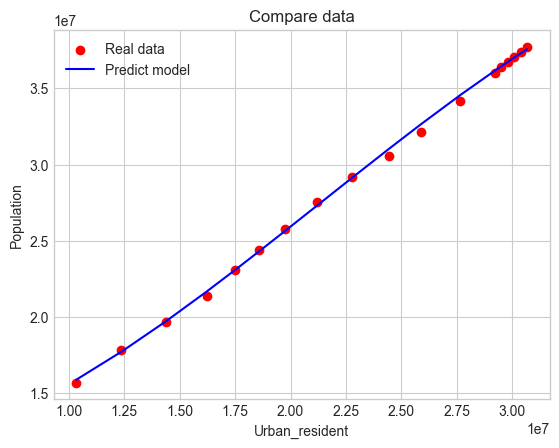

In [ ]:
visualizeDataForPoly(X,y1,y1Preds,bestFieldForPreds,fieldWantToPredict)

## Answer the question


Overload the predict function for clearly output

In [ ]:
def predictField(country,field,dataFrame,year,powN):
    theta, R = buildModelField(country,dataFrame,field,powN)
    large = round(caculateFieldForYear(theta,year))
    return large

### 1/ Predict population of country in area to 2025

In [ ]:
listField

['Country', 'Year', 'Population', 'Change', 'Migrate', 'Urban_resident']

In [ ]:
# predictYear = 2025
# predictField(listCountry[1],listField[2],df,predictYear,powFieldValue)
listCountry[1]


'canada'

### Let see how the population of world change from 1995 to 2020

In [ ]:
popInfo = df.groupby('Year').sum().reset_index()
popInfo['Country']='Area'
# popInfo[['Year','Population']]
popInfo

C:\Users\ACER\AppData\Local\Temp\ipykernel_1256\4011269455.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  popInfo = df.groupby('Year').sum().reset_index()


,Year,Population,Change,Migrate,Urban_resident,Country
0,1955,1736472303,31792132,484295,424391960,Area
1,1960,1909690216,34643581,870627,503369903,Area
2,1965,2114428465,40947649,403884,591235624,Area
3,1970,2373472188,51808745,612899,677671110,Area
4,1975,2643422948,53990150,497739,777787043,Area
5,1980,2903585423,52032497,600682,905007716,Area
6,1985,3187536627,56790238,718858,1067380016,Area
7,1990,3505884221,63669521,559064,1251042572,Area
8,1995,3787540525,56331264,69553,1443601155,Area
9,2000,4053690154,53229923,734446,1647136231,Area


### Start to predict all around the Area
#### 1. Predict population until 2025

### The question is how the population of this area in 2025
- This question can help user to see the population of this area => Realizing the area's population growth rate so that we can have some population policies

In [ ]:
powFieldValue, minRFieldValue = findTheBestNForMinRField('Area',listField[5],popInfo)
printInfoField('Area',listField[2],powFieldValue, minRFieldValue)

Predict Population for Area country.
The minimum value of R is: 48954961.63583117, and N (maximum power of x) is: 1.
The above information means that the Population deviation when using the X^(1) model to predict is from real data.


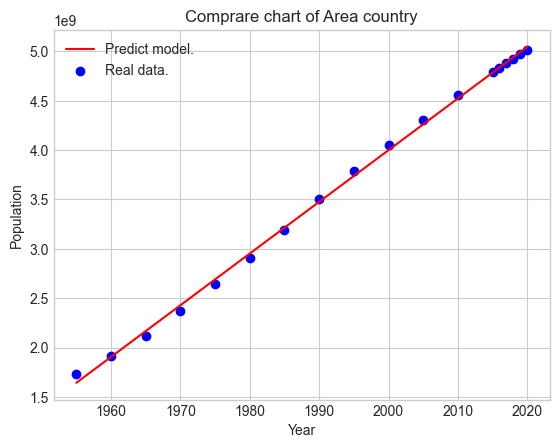

In [ ]:
compareFieldWithRealData('Area',listField[2],popInfo,powFieldValue)

### Predict result

,Population predict
2021,5098442796
2022,5150798099
2023,5203153403
2024,5255508706
2025,5307864010
2026,5360219314
2027,5412574617
2028,5464929921
2029,5517285224
2030,5569640528


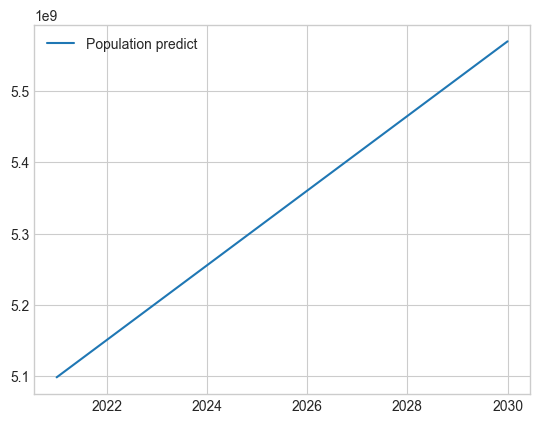

In [ ]:
predictPop={}
for i in range (2021,2031):
    predictYear = i
    predictPop.setdefault(i,predictField('Area',listField[2],popInfo,predictYear,powFieldValue))

# predictPop=pd.DataFrame
predictPop=pd.DataFrame.from_dict(predictPop,orient='index',columns=['Population predict'])
predictPop.plot()
predictPop.reset_index().rename({'index':'Year'},inplace=True)
predictPop

### 2. Predict each country in next 5 years (2025)

,Population
bermuda,61079
canada,39368708
greenland,53151
hoa-ky,343550180
saint-pierre-va-miquelon,6245
a-rap-xe-ut,39604435
afghanistan,44679874
an-do,1456719081
armenia,2556170
azerbaijan,10539189


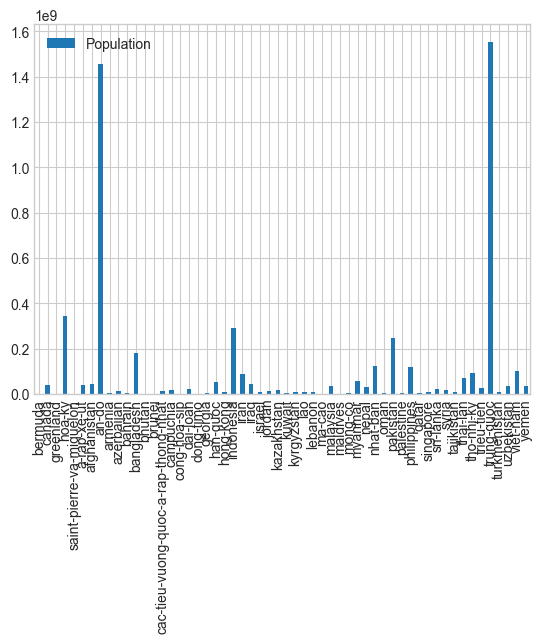

In [ ]:

popPredict={}
for i in range(0,len(listCountry)):
    powFieldValue, minRFieldValue = findTheBestNForMinRField(listCountry[i],listField[5],df)
    # printInfoField(listCountry[i],listField[2],powFieldValue, minRFieldValue)
    predictYear = 2025
    # predictField(listCountry[i],listField[2],df,predictYear,powFieldValue)
    popPredict.setdefault(listCountry[i],predictField(listCountry[i],listField[2],df,predictYear,powFieldValue))

popPredict=pd.DataFrame.from_dict(popPredict,orient='index',columns=['Population'])
popPredict.plot.bar()
popPredict.reset_index().rename({'index':'Country'},inplace=True)
popPredict

### 3. Predict urbanization of country in area

,Urbanization predict
2021,2571655669
2022,2608345434
2023,2645035199
2024,2681724964
2025,2718414729
2026,2755104493
2027,2791794258
2028,2828484023
2029,2865173788
2030,2901863553


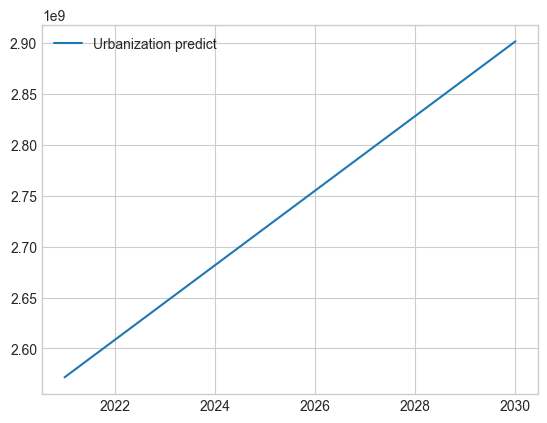

In [ ]:
predictUrbanization={}
powFieldValue, minRFieldValue = findTheBestNForMinRField('Area',listField[5],popInfo)
for i in range (2021,2031):
    predictYear = i
    predictUrbanization.setdefault(i,predictField('Area',listField[5],popInfo,predictYear,powFieldValue))

# predictPop=pd.DataFrame
predictUrbanization=pd.DataFrame.from_dict(predictUrbanization,orient='index',columns=['Urbanization predict'])
predictUrbanization.plot()
predictUrbanization

### 4.Predict migration of country in area in 2025

In [ ]:

newDfPop=df.groupby(['Country','Year']).sum().reset_index()
migrantCountries=(newDfPop['Year']==2020)
temp=newDfPop.loc[migrantCountries]['Country'].reset_index()
migrateCountry=[]
immigrateCountry=[]
for i in range(0,len(temp['Country'])):
    powFieldValue, minRFieldValue = findTheBestNForMinRField(temp['Country'][i],listField[4],df)
    # printInfoField('World',listField[5],powFieldValue, minRFieldValue)
    predictYear = 2025
    # predictField(temp['Country'][i],listField[4],df,predictYear,powFieldValue)
    if predictField(temp['Country'][i],listField[4],df,predictYear,powFieldValue)>0:
        migrateCountry.append(temp['Country'][i])
    else: immigrateCountry.append(temp['Country'][i])

print(f"In 2025 the migration will move from {migrateCountry} to {immigrateCountry}")
# pridictMigrate=newDfPop.loc[newDfPop['Country']==Migrant_countries]


In 2025 the migration will move from ['an-do', 'armenia', 'bahrain', 'bermuda', 'canada', 'han-quoc', 'hoa-ky', 'hong-kong', 'iran', 'iraq', 'israel', 'kuwait', 'maldives', 'myanmar', 'nepal', 'nhat-ban', 'oman', 'palestine', 'saint-pierre-va-miquelon', 'singapore', 'thai-lan', 'tho-nhi-ky', 'yemen'] to ['a-rap-xe-ut', 'afghanistan', 'azerbaijan', 'bangladesh', 'bhutan', 'brunei', 'cac-tieu-vuong-quoc-a-rap-thong-nhat', 'campuchia', 'cong-hoa-sip', 'dai-loan', 'dong-timo', 'georgia', 'greenland', 'indonesia', 'jordan', 'kazakhstan', 'kyrgyzstan', 'lao', 'lebanon', 'ma-cao', 'malaysia', 'mong-co', 'pakistan', 'philippines', 'qatar', 'sri-lanka', 'syria', 'tajikistan', 'trieu-tien', 'trung-quoc', 'turkmenistan', 'uzbekistan', 'viet-nam']


### 5. Predict popular structure of Country in Year 

In [ ]:
def predictStruct(Country,Year):
    indexName=['Population Structure']
    popPredict=[]
    urbanPredict=[]
    powFieldValue, minRFieldValue = findTheBestNForMinRField(Country,listField[5],df)
    pop=predictField(Country,listField[2],df,Year,powFieldValue)
    popPredict.append(pop)
    urban=predictField(Country,listField[5],df,Year,powFieldValue)
    urbanPredict.append(urban)
    getPredictValue=pd.DataFrame({'Population': popPredict,'Urban_resident': urbanPredict},index=indexName)
    getPredictValue.plot.bar(stacked=True)
    print(f'Urbanization {urban} and population {pop} of {Country} in {Year} ')

### Predict for Bermuda in 2025

Urbanization 59151 and population 61079 of bermuda in 2025 


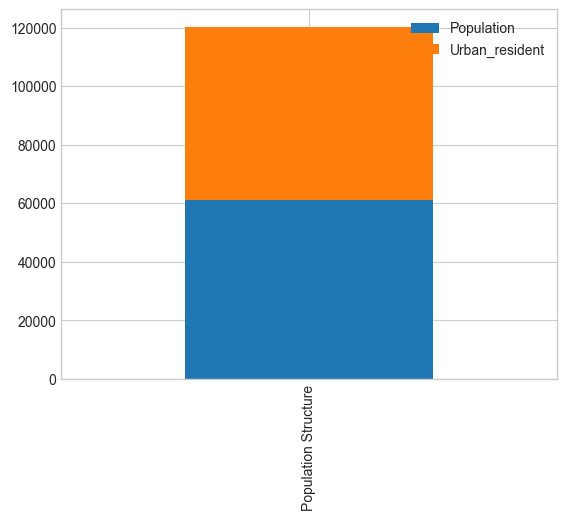

In [ ]:
predictStruct(listCountry[0],2025)

Urbanization 27896456 and population 48335202 of uzbekistan in 2050 


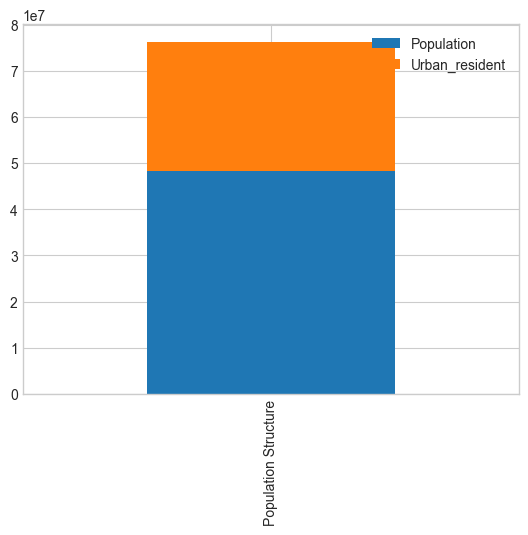

In [ ]:
predictStruct(listCountry[53],2050)

### Predict for Kazakhstan in 2070

Urbanization 7439542 and population 15152626 of kazakhstan in 2070 


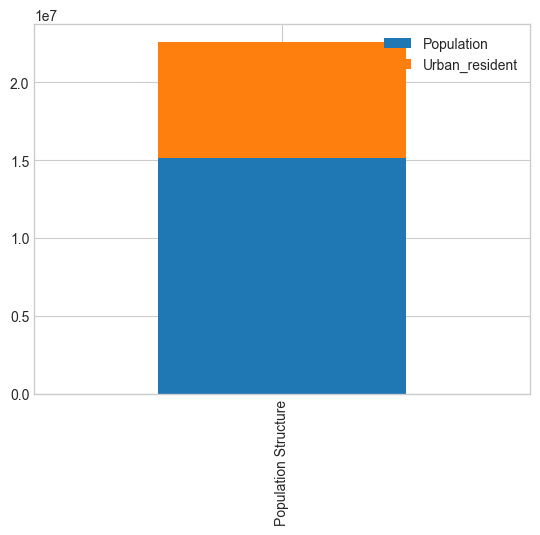

In [ ]:
predictStruct(listCountry[27],2070)